In [1]:
#!/usr/bin/env python
import json
import pandas as pd
import numpy as np

from flatten_json import flatten
from dateutil import parser
from math import sqrt,pow



def pre1(match_id):
    

    filename_event = f'events-ma13-{match_id}.json'
    filename_metadata = '2021-08-19-jpl-season-2020-2021-squads.csv'
    path = 'E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\data\\'

    tracking_cols = ['timestamp', 'time_of_current_half', 'half_indicator', 'match_not_in_play',
                     'player_1_teamId', 'player_1_objectId', 'player_1_jerseyNum', 'player_1_x', 'player_1_y',
                     'player_2_teamId', 'player_2_objectId', 'player_2_jerseyNum', 'player_2_x', 'player_2_y',
                     'player_3_teamId', 'player_3_objectId', 'player_3_jerseyNum', 'player_3_x', 'player_3_y',
                     'player_4_teamId', 'player_4_objectId', 'player_4_jerseyNum', 'player_4_x', 'player_4_y',
                     'player_5_teamId', 'player_5_objectId', 'player_5_jerseyNum', 'player_5_x', 'player_5_y',
                     'player_6_teamId', 'player_6_objectId', 'player_6_jerseyNum', 'player_6_x', 'player_6_y',
                     'player_7_teamId', 'player_7_objectId', 'player_7_jerseyNum', 'player_7_x', 'player_7_y',
                     'player_8_teamId', 'player_8_objectId', 'player_8_jerseyNum', 'player_8_x', 'player_8_y',
                     'player_9_teamId', 'player_9_objectId', 'player_9_jerseyNum', 'player_9_x', 'player_9_y',
                     'player_10_teamId', 'player_10_objectId', 'player_10_jerseyNum', 'player_10_x', 'player_10_y',
                     'player_11_teamId', 'player_11_objectId', 'player_11_jerseyNum', 'player_11_x', 'player_11_y',
                     'player_12_teamId', 'player_12_objectId', 'player_12_jerseyNum', 'player_12_x', 'player_12_y',
                     'player_13_teamId', 'player_13_objectId', 'player_13_jerseyNum', 'player_13_x', 'player_13_y',
                     'player_14_teamId', 'player_14_objectId', 'player_14_jerseyNum', 'player_14_x', 'player_14_y',
                     'player_15_teamId', 'player_15_objectId', 'player_15_jerseyNum', 'player_15_x', 'player_15_y',
                     'player_16_teamId', 'player_16_objectId', 'player_16_jerseyNum', 'player_16_x', 'player_16_y',
                     'player_17_teamId', 'player_17_objectId', 'player_17_jerseyNum', 'player_17_x', 'player_17_y',
                     'player_18_teamId', 'player_18_objectId', 'player_18_jerseyNum', 'player_18_x', 'player_18_y',
                     'player_19_teamId', 'player_19_objectId', 'player_19_jerseyNum', 'player_19_x', 'player_19_y',
                     'player_20_teamId', 'player_20_objectId', 'player_20_jerseyNum', 'player_20_x', 'player_20_y',
                     'player_21_teamId', 'player_21_objectId', 'player_21_jerseyNum', 'player_21_x', 'player_21_y',
                     'player_22_teamId', 'player_22_objectId', 'player_22_jerseyNum', 'player_22_x', 'player_22_y',
                     'to_del_1',
                     'ball_x', 'ball_y', 'ball_z',
                     'to_del_2']
    filename = f'tracking-data-{match_id}-25fps.txt'
    tracking = pd.read_csv(path + filename, sep=";|,|:", names=tracking_cols, header=None, engine='python')
    tracking = tracking.drop(labels=['to_del_1', 'to_del_2'], axis=1)
    #drop unnecessary cols
    to_del_cols = [c for c in tracking.columns.tolist() if 'jerseyNum' in c]
    tracking = tracking.drop(labels=to_del_cols, axis=1)

    temp = tracking[tracking['half_indicator'] == 1]['time_of_current_half'].max()
    tracking['timeMilliSec'] = tracking['time_of_current_half'] + temp * (tracking['half_indicator'] - 1)


    with open(path + filename_event) as f:
        d = json.load(f)


    def jsonNormalize(data):
        dic_flattened = (flatten(dd) for dd in data)
        df = pd.DataFrame(dic_flattened)
        return df


    df1 = jsonNormalize(d['liveData']['event'])
    interesting_periods = [1, 2, 3, 4, 5]
    interesting_event_ids = [1, 2, 3, 7, 8, 10, 11, 13, 14, 15, 16, 74]
    df2 = df1[df1['typeId'].apply(lambda x: x == 32)]
    df1 = df1[df1['periodId'].apply(lambda x: x in interesting_periods)]
    df1 = df1[df1['typeId'].apply(lambda x: x in interesting_event_ids)]

    id_mapping = pd.read_csv(path + filename_metadata)
    id_mapping = id_mapping[['matchName', 'stats_id']]
    id_mapping.columns = ['playerName', 'playerTrackingId']


    def get_tr_id(playerNames):
        ids = []
        for playerName in playerNames:
            id = int(id_mapping[id_mapping['playerName'] == playerName]['playerTrackingId'].values[0])
            ids.append(id)
        return ids


    df1['playerTrackingId'] = get_tr_id(df1['playerName'].values)

    # Calculate remaining time from half
    # Need to group by period because extra time may differ

    df1['to_sec'] = df1['timeMin'] * 60 + df1['timeSec']
    df1['sec_remaining'] = df1.groupby('periodId').to_sec.transform('max') - df1.to_sec

    temp = df1.iloc[0]['timeStamp'].replace('Z', '-01')
    temp2 = df1[(df1['periodId'] == 2) & (df1['to_sec'] == 45 * 60)]['timeStamp'].values[0].replace('Z', '-01')
    OFFSET_1 = tracking.iloc[0]['timestamp'] - parser.parse(temp).timestamp() * 1000
    OFFSET_2 = tracking[(tracking['half_indicator'] == 2) & (tracking['time_of_current_half'] == 0)]['timestamp'].values[
                   0] - parser.parse(temp2).timestamp() * 1000


    # syncs the tracking and event timestamps for better matching later
    def getmillisecs(timestamps, half):
        out = []
        for timestamp in timestamps:
            timestamp = timestamp.replace('Z', '-01')
            if half == 1:
                yourdate = parser.parse(timestamp).timestamp() * 1000 + OFFSET_1
            else:
                yourdate = parser.parse(timestamp).timestamp() * 1000 + OFFSET_2
            out.append(yourdate)
        return out


    firsthalf = df1.loc[df1['periodId'] == 1]['timeStamp'].values.tolist()
    secondhalf = df1.loc[df1['periodId'] == 2]['timeStamp'].values.tolist()
    first = getmillisecs(firsthalf, 1)
    second = getmillisecs(secondhalf, 2)
    timestamps = first + second
    df1['timeStamp'] = timestamps

    matchinfo = jsonNormalize(d['matchInfo']['contestant'])

    home_team_id = ''

    if matchinfo.loc[0,'position'] == 'home':
        df1.loc[df1.contestantId == matchinfo.loc[0,'id'],'event_team'] = 0
        home_team_id = matchinfo.loc[0,'id']
        df1.loc[df1.contestantId == matchinfo.loc[1,'id'],'event_team'] = 1
    else:
        df1.loc[df1.contestantId == matchinfo.loc[0,'id'],'event_team'] = 1
        df1.loc[df1.contestantId == matchinfo.loc[1,'id'],'event_team'] = 0
        home_team_id = matchinfo.loc[1,'id']

    df1['home_attack_dir'] = df2.loc[df2.contestantId == home_team_id,'qualifier_0_value'].values[0]


    half1_team1_attackdir = df2['qualifier_0_value'].iloc[0]  # 'Right to Left' or 'Left to Right'

    df1['Pass_end_x'] = np.nan
    df1['Pass_end_y'] = np.nan
    q_ids=[]
    q_vals=[]
    for column in df1:
        if column.startswith('qualifier') and column.endswith('qualifierId'):
            q_ids.append(column.split('_')[1])
        elif column.startswith('qualifier') and column.endswith('value'):
            q_vals.append(column.split('_')[1])
    qs=list(set(q_ids).intersection(q_vals))

    if (half1_team1_attackdir == 'Right to Left'):
        df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['x']] = 100 - df1['x']
        df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['x']] = 100 - df1['x']
        df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['y']] = 100 - df1['y']
        df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['y']] = 100 - df1['y']
        # transform the pass destination too
        # count qualifiers

        # X:
        for colnum in qs:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
            # Y:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

    elif (half1_team1_attackdir == 'Left to Right'):
        df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['x']] = 100 - df1['x']
        df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['x']] = 100 - df1['x']
        df1.loc[(df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]), ['y']] = 100 - df1['y']
        df1.loc[(df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]), ['y']] = 100 - df1['y']

        # transform the pass destination too
        # X:
        for colnum in qs:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &  # here
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
            # Y:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

    # Pass_end_x and Pass_end_y now only contains the values that need to be flipped, so:
    df1['Pass_end_x'] = pd.to_numeric(df1.Pass_end_x, errors='coerce')
    df1['Pass_end_y'] = pd.to_numeric(df1.Pass_end_y, errors='coerce')

    df1['Pass_end_x'] = 100 - df1['Pass_end_x']
    df1['Pass_end_y'] = 100 - df1['Pass_end_y']

    # Now add the ones that will not need flipping.
    if (half1_team1_attackdir == 'Right to Left'):

        # X: (do we need typeId too??)
        for colnum in qs:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
            # Y:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

    elif (half1_team1_attackdir == 'Left to Right'):
        # X:
        for colnum in qs:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 140) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_x']] = (df1[f'qualifier_{colnum}_value'])
            # Y:
            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 1) & (df1['contestantId'] == df2['contestantId'].iloc[0]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

            df1.loc[(df1[f'qualifier_{colnum}_qualifierId'] == 141) &
                    (df1['periodId'] == 2) & (df1['contestantId'] == df2['contestantId'].iloc[1]),
                    ['Pass_end_y']] = (df1[f'qualifier_{colnum}_value'])

    df1['Pass_end_x'] = pd.to_numeric(df1.Pass_end_x, errors='coerce')
    df1['Pass_end_y'] = pd.to_numeric(df1.Pass_end_y, errors='coerce')
    # Now scale from 100x100 to 105x68


    df1['x'] = df1['x'] * 1.05
    df1['y'] = df1['y'] * 0.68
    df1['Pass_end_x'] = df1['Pass_end_x'] * 1.05
    df1['Pass_end_y'] = df1['Pass_end_y'] * 0.68

    # tracking flip y
    tracking['ball_y'] = 68 - tracking['ball_y']
    for num in range(1, 23):
        tracking[f'player_{num}_y'] = 68 - tracking[f'player_{num}_y']

    # calculating velocity (speed and direction) - for players
    dT = tracking.loc[1,'timestamp']-tracking.loc[0,'timestamp']
    MAXSPEED = 12
    MOVING_WINDOW =7
    #ma_window = np.ones( MOVING_WINDOW ) / MOVING_WINDOW 

    for p_num in range(1,23):
        # directions
        Vx = tracking[f'player_{p_num}_x'].diff() / dT
        Vy = tracking[f'player_{p_num}_y'].diff() / dT

        # get rid of outliers
        if MAXSPEED > 0:
            raw_speed = np.sqrt((Vx**2)+(Vy**2))
            Vx[ raw_speed>MAXSPEED ] = np.nan
            Vy[ raw_speed>MAXSPEED ] = np.nan

        # smoothing
        # calculate first half velocity     
        Vx = Vx.rolling(MOVING_WINDOW,min_periods = 0,center=False).mean()
        Vy = Vy.rolling(MOVING_WINDOW,min_periods = 0,center=False).mean()

        # apply speed and direction values
        tracking[f'player_{p_num}_direction_x'] = Vx
        tracking[f'player_{p_num}_direction_y'] = Vy
        tracking[f'player_{p_num}_speed'] = np.sqrt((Vx**2)+(Vy**2))
        tracking.loc[:,[f'player_{p_num}_direction_x',f'player_{p_num}_direction_y',f'player_{p_num}_speed']] =\
             tracking.loc[:,[f'player_{p_num}_direction_x',f'player_{p_num}_direction_y',f'player_{p_num}_speed']].fillna(0)

    # calculating velocity (speed and direction) - for ball
    Vbx = tracking['ball_x'].diff() / dT
    Vby = tracking['ball_y'].diff() / dT
    if MAXSPEED > 0:
        raw_speed = np.sqrt(Vbx**2+Vby**2)
        Vbx[ raw_speed>MAXSPEED ] = np.nan
        Vby[ raw_speed>MAXSPEED ] = np.nan
    Vbx = Vbx.rolling(MOVING_WINDOW,min_periods = 0, center= False).mean()
    Vby = Vby.rolling(MOVING_WINDOW,min_periods = 0, center= False).mean()
    tracking['ball_direction_x'] = Vx
    tracking['ball_direction_y'] = Vy
    tracking['ball_speed'] = np.sqrt((Vx**2)+(Vy**2))

    tracking.loc[:,['ball_direction_x','ball_direction_y','ball_speed']] = tracking.loc[:,['ball_direction_x','ball_direction_y','ball_speed']].fillna(0)

    parsed_path = 'E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\parsed\\'
    tracking.to_csv(parsed_path + f'flat-tracking-{match_id}-25fps.csv', index=False)

    df1.to_csv(parsed_path + f'events-ma13-with-features-{match_id}.csv', index=False)
    return tracking

In [85]:
#need:  -function(distance_pos) that calcs distance between two points
#       -function(distance_time) that calcscthe "distance" between the tracking and event record's timestamp 
#           (one is in milliseconds, other is minutes and seconds separately, so rounding is necessary) 
#       -function that loops through the eventlist it recieves and does what's described in the how section
#            with the help of the distance_pos and distance_time function



#what I want:   loop through the events of a match and pair them with tracking data from the same match.
#
#how:           take first event record, measure distance between event point (event_x,event_y) and ball's position
#               , then event point to player's position (who 'commits' the event)
#               Do this, while the distances are getting lower. If distances are increasing stop and match the event
#               record with the last non-ncreasing tracking record.
#               Do this for every event record.
# 
#               #2 -- Try with event data timeStamp??-has miliseconds! 

#TRACKING DATA NEEDS TO BE CLEANED FIRST - done
from inspect import FrameInfo
from math import sqrt
from statistics import mean
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

def pre2(match_id):

    #opening files
    parsed_path = 'E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\parsed\\'
    tracking_fn=f'flat-tracking-{match_id}-25fps.csv'
    event_fn=f'events-ma13-with-features-{match_id}.csv'
    tracking_df = pd.read_csv(parsed_path+tracking_fn)
    event_df = pd.read_csv(parsed_path+event_fn)

    home_attack_dir=event_df.loc[0,'home_attack_dir']

    #helper functions for calculating disance between timestamps
    def distance_time(time_from, time_to):
        return abs(time_to - time_from)
    def conv_milisec_to_sec(milliseconds):
        return round((milliseconds)/1000)
    def conv_min_sec_to_sec(minute,second):
        return (minute*60+second)
    #helper functions for calculating distance between positions
    def distance_pos(x_1,y_1,x_2,y_2):
        if x_1 == np.nan or y_1 == np.nan or x_2 == np.nan or y_2 == np.nan:
            return np.inf
        else:        
            return sqrt((x_2-x_1)**2+(y_2-y_1)**2)


    def get_player_pos(playerId,frame):
        x=0
        y=0
        values =frame.values.tolist()
        for elem in values:
            i=values.index(elem)
            if elem == playerId:
                x=frame[i+2]
                y=frame[i+3]
        return x,y

    #calculate distance metric for an event and trackinf frame pair
    def calc_distance(event,frame,justTime):
        if not justTime:
            #calc time distance
            ev_time = event['timeStamp']
            fr_time = frame['timestamp']
            time_dist = distance_time(ev_time,fr_time)
            #calc positional distance
            #   -ball
            pos_distance_ball = distance_pos(event['x'],event['y'],frame['ball_x'],frame['ball_y'])
            #   -player performing the event
            player = event['playerTrackingId']
            player_x,player_y = get_player_pos(player,frame)
            pos_distance_player = distance_pos(event['x'],event['y'],player_x,player_y)
            #return overall distance
            dist=time_dist*0.33+pos_distance_ball*0.33+pos_distance_player*0.33
        else:
            #calc time distance
            ev_time = event['timeStamp']
            fr_time = frame['timestamp']
            dist = distance_time(ev_time,fr_time)
        return (dist)

    #evaluates the syncing - with the difference between tracking player position and event position
    def eval(event_df,tracking_df):
        distances=[]
        distances_ball=[]
        distances_x=[]
        distances_y=[]
        for ev_i,event in event_df.iterrows():
            frame = tracking_df.iloc[event['frame_id']]
            player_x, player_y = get_player_pos(event['playerTrackingId'],frame)
            distance = distance_pos(event['x'],event['y'],player_x,player_y)
            distances_ball.append(distance_pos(event['x'],event['y'],frame['ball_x'],frame['ball_y']))
            distances_x.append(abs(event['x']-player_x))
            distances_y.append(abs(event['y']-player_y))
            distances.append(distance)
        return distances,distances_ball,distances_x,distances_y

    #match events until distance gets lower, stop when it doesn't
    def match_events(event_df,tracking_df,justTime):
        frame_ids=[]
        distances=[]
        tr_i=0
        for ev_i, ev_elem in event_df.iterrows():
            min_dist=calc_distance(ev_elem,tracking_df.iloc[tr_i],justTime)
            dist = calc_distance(ev_elem,tracking_df.iloc[tr_i+1],justTime)
            while (dist<=min_dist):
                tr_i+=1
                min_dist=calc_distance(ev_elem,tracking_df.iloc[tr_i],justTime)
                if tr_i+1 >= tracking_df.shape[0]: # additional to manage exceptions
                    break
                dist = calc_distance(ev_elem,tracking_df.iloc[tr_i+1],justTime)
            frame_ids.append(tr_i)
            distances.append(min_dist)
        return frame_ids,distances

    #look at the next 1500 tracking records and choose the one with the smallest distance
    def match_events_2(event_df,tracking_df,justTime):
        frame_ids=[]
        distances=[]
        tr_i=0
        for ev_i, ev_elem in event_df.iterrows():
            fr_dist=[]
            end_i = min(len(tracking_df.index),tr_i+1200)
            for i in range(tr_i,end_i):
                if i >= tracking_df.shape[0]: # additional to manage exceptions
                    break
                fr_dist.append(calc_distance(ev_elem,tracking_df.iloc[i],justTime))    
            min_dist=min(fr_dist)
            tr_i=tr_i+fr_dist.index(min_dist)
            frame_ids.append(tr_i)
            distances.append(min_dist)
        return frame_ids,distances

    def match_events_3(event_df,tracking_df):
        frame_ids=[]
        for ev_i, event in event_df.iterrows():
            rounded_time = int(40* round(float(event['timeStamp'])/40))
            # fr_id_l = tracking_df.index[tracking_df['timestamp']==rounded_time].tolist()
            fr_id_l = tracking_df.index[tracking_df['timestamp']>=rounded_time].tolist()
            if fr_id_l:
                frame_ids.append(fr_id_l[0])
            else:
                print("error")
                frame_ids.append(np.nan)
        return frame_ids


    # frame_ids,distances=match_events(event_df,tracking_df,True)
    # frame_ids2,distances2=match_events(event_df,tracking_df,False)
    # frame_ids3=match_events_3(event_df,tracking_df)
    frame_ids4,distances4=match_events_2(event_df,tracking_df,False)
    # frame_ids5,distances5=match_events_2(event_df,tracking_df,True)


    # event_df=event_df.copy()
    # event_df2=event_df.copy()
    # event_df3=event_df.copy()
    event_df4=event_df.copy()
    # event_df5=event_df.copy()


    # event_df['frame_id']=frame_ids
    # event_df['distance']=distances
    # event_df2['frame_id']=frame_ids2
    # event_df2['distance']=distances2
    # event_df3['frame_id']=frame_ids3
    # event_df3.dropna(subset=['frame_id'], axis=0, inplace=True)
    # event_df3['frame_id'] = event_df3['frame_id'].astype('int')
    event_df4['frame_id']=frame_ids4
    event_df4.drop_duplicates(['frame_id']) #TODO HA VAN ILYEN INKÁBB DOBJUK EL AZ EGÉSZ MECCSET
    # #event_df4['distance']=distances4
    # event_df5['frame_id']=frame_ids5


    tracking_df['frame_id'] = tracking_df.index

    tracking_w_events =pd.merge(tracking_df,event_df4,how='outer',on=['frame_id'],suffixes=('_tracking','_event'))


    synced_events = tracking_w_events[pd.notna(tracking_w_events['eventId'])].copy()

    return synced_events




In [279]:
def distance_pos(x_1,y_1,x_2,y_2):
    return sqrt((x_2-x_1)**2+(y_2-y_1)**2)
def min_dist_to_players(x,y,row):
    dist = np.inf
    dist_teamId = np.inf
    for i in range(1, 23):
        if row[[f'player_{i}_teamId', f'player_{i}_x', f'player_{i}_y']].isna().any():
            continue
        else:
            dist_p = distance_pos(x,y,row[f'player_{i}_x'], row[f'player_{i}_y'])
            if dist < dist_p:
                dist = dist_p
                dist_teamId = row[f'player_{i}_teamId']
    return dist_teamId
def match_pass_end(row,tracking_df):
    tr_i = row['frame_id']
    if tr_i+1 >= tracking_df.shape[0]:
        return tr_i
    min_dist = distance_pos(row['Pass_end_x'],row['Pass_end_y'],tracking_df.iloc[tr_i]['ball_x'],tracking_df.iloc[tr_i]['ball_y'])
    dist = distance_pos(row['Pass_end_x'],row['Pass_end_y'],tracking_df.iloc[tr_i+1]['ball_x'],tracking_df.iloc[tr_i+1]['ball_y'])
    while (dist<=min_dist):
        tr_i+=1
        min_dist = distance_pos(row['Pass_end_x'],row['Pass_end_y'],tracking_df.iloc[tr_i]['ball_x'],tracking_df.iloc[tr_i]['ball_y'])
        if tr_i+1 >= tracking_df.shape[0]: # additional to manage exceptions
            break
        dist = distance_pos(row['Pass_end_x'],row['Pass_end_y'],tracking_df.iloc[tr_i+1]['ball_x'],tracking_df.iloc[tr_i+1]['ball_y'])
    return tr_i

In [84]:
def get_ns_before(row, cols, df, colname):
    #colname determines how many seconds we want to go back to
    value = df.loc[(df['time_of_current_half'] < row[colname]) & (df['half_indicator'] == row['half_indicator']) & (df['time_of_current_half'] > row[colname] - 5000), cols]
    if len(value) == 0:
        # return tracking_w_events.iloc[0][['player_1_x','player_2_x']]
        df_beginning = df[df['half_indicator'] == row['half_indicator']].reset_index() # reset index to reach the first row of the new df
        r = 0
        return df_beginning.loc[r, cols]
    else:
        return value.values[-1]

In [92]:
def get_players(row, attacking_team, needs_flipping):
    defending_team = 0
    if attacking_team == 0:
        defending_team = 1
    attack = {}
    defend = {}
    attack_before = {}
    defend_before = {}
    attacking_team_gk = 0
    defending_team_gk = 0
    attacking_team_gk_bef = 0
    defending_team_gk_bef = 0
    recipient = 0
    carrier = 0
    for num in range(1, 23):
        # separate current and 5 sec before
        if row[f'player_{num}_teamId'] == attacking_team:
            if needs_flipping:
                attack[num] = 105 - row[f'player_{num}_x']
            else:
                attack[num] = row[f'player_{num}_x']
        if row[f'player_{num}_teamId'] == defending_team:
            if needs_flipping:
                defend[num] = 105 - row[f'player_{num}_x']
            else:
                defend[num] = row[f'player_{num}_x']
        if row[f'player_{num}_teamId'] == attacking_team + 3:
            attacking_team_gk = num
        if row[f'player_{num}_teamId'] == defending_team + 3:
            defending_team_gk = num
        if row[f'player_{num}_teamId_n_sec_before'] == attacking_team:
            if needs_flipping:
                attack_before[num] = 105 - row[f'player_{num}_x_n_sec_before']
            else:
                attack_before[num] = row[f'player_{num}_x_n_sec_before']
        if row[f'player_{num}_teamId_n_sec_before'] == defending_team:
            if needs_flipping:
                defend_before[num] = 105 - row[f'player_{num}_x_n_sec_before']
            else:
                defend_before[num] = row[f'player_{num}_x_n_sec_before']
        if row[f'player_{num}_teamId_n_sec_before'] == attacking_team + 3:
            attacking_team_gk_bef = num
        if row[f'player_{num}_teamId_n_sec_before'] == defending_team + 3:
            defending_team_gk_bef = num 
        if row['next_tracking_id'] == row[f'player_{num}_objectId']:
            recipient = num
        if row['playerTrackingId'] == row[f'player_{num}_objectId']:
            carrier = num        
    attackers = sorted(attack.items(), key=lambda x:x[1], reverse=True)
    defenders = sorted(defend.items(), key=lambda x:x[1], reverse=True)
    attackers_bef = sorted(attack.items(), key=lambda x:x[1], reverse=True)
    defenders_bef = sorted(defend.items(), key=lambda x:x[1], reverse=True)
    attacker_nums = [a[0] for a in attackers[:5]]
    defender_nums = [a[0] for a in defenders[:5]]
    attacker_nums_bef = [a[0] for a in attackers_bef[:5]]
    defender_nums_bef = [a[0] for a in defenders_bef[:5]]
    result = pd.Series(dtype='float64')
    i = 1
    for n in attacker_nums:
        
        result = pd.concat([result, row[[f'player_{n}_x', f'player_{n}_y', f'player_{n}_direction_x', f'player_{n}_direction_y', f'player_{n}_speed']].set_axis([f'attacker_{i}_x', f'attacker_{i}_y', f'attacker_{i}_direction_x', f'attacker_{i}_direction_y', f'attacker_{i}_speed'], axis=0)])
        if needs_flipping:
            result[f'attacker_{i}_x'] = 105 - result[f'attacker_{i}_x']
            result[f'attacker_{i}_direction_x'] = (-1) * result[f'attacker_{i}_direction_x']
        i = i + 1
    i = 1
    for n in defender_nums:
        result = pd.concat([result, row[[f'player_{n}_x', f'player_{n}_y', f'player_{n}_direction_x', f'player_{n}_direction_y', f'player_{n}_speed']].set_axis([f'defender_{i}_x', f'defender_{i}_y', f'defender_{i}_direction_x', f'defender_{i}_direction_y', f'defender_{i}_speed'], axis=0)])
        if needs_flipping:
            result[f'defender_{i}_x'] = 105 - result[f'defender_{i}_x']
            result[f'defender_{i}_direction_x'] = (-1) * result[f'defender_{i}_direction_x']
        i = i + 1
    i = 1
    for n in attacker_nums_bef:
        result = pd.concat([result, row[[f'player_{n}_x_n_sec_before', f'player_{n}_y_n_sec_before', f'player_{n}_direction_x_n_sec_before', f'player_{n}_direction_y_n_sec_before', f'player_{n}_speed_n_sec_before']].set_axis([f'attacker_{i}_x_n_sec_before', f'attacker_{i}_y_n_sec_before', f'attacker_{i}_direction_x_n_sec_before', f'attacker_{i}_direction_y_n_sec_before', f'attacker_{i}_speed_n_sec_before'], axis=0)])
        if needs_flipping:
            result[f'attacker_{i}_x_n_sec_before'] = 105 - result[f'attacker_{i}_x_n_sec_before']
            result[f'attacker_{i}_direction_x_n_sec_before'] = (-1) * result[f'attacker_{i}_direction_x_n_sec_before']
        i = i + 1
    i = 1
    for n in defender_nums_bef:
        result = pd.concat([result, row[[f'player_{n}_x_n_sec_before', f'player_{n}_y_n_sec_before', f'player_{n}_direction_x_n_sec_before', f'player_{n}_direction_y_n_sec_before', f'player_{n}_speed_n_sec_before']].set_axis([f'defender_{i}_x_n_sec_before', f'defender_{i}_y_n_sec_before', f'defender_{i}_direction_x_n_sec_before', f'defender_{i}_direction_y_n_sec_before', f'defender_{i}_speed_n_sec_before'], axis=0)])
        if needs_flipping:
            result[f'defender_{i}_x_n_sec_before'] = 105 - result[f'defender_{i}_x_n_sec_before']
            result[f'defender_{i}_direction_x_n_sec_before'] = (-1) * result[f'defender_{i}_direction_x_n_sec_before']
        i = i + 1
    if attacking_team_gk != 0:
        result = pd.concat([result, row[[f'player_{attacking_team_gk}_x', f'player_{attacking_team_gk}_y', f'player_{attacking_team_gk}_direction_x', f'player_{attacking_team_gk}_direction_y', f'player_{attacking_team_gk}_speed']].set_axis([f'attacking_team_keeper_x', f'attacking_team_keeper_y', f'attacking_team_keeper_direction_x', f'attacking_team_keeper_direction_y', f'attacking_team_keeper_speed'], axis=0)])
        if needs_flipping:
            result[f'attacking_team_keeper_x'] = 105 - result[f'attacking_team_keeper_x']
            result[f'attacking_team_keeper_direction_x'] = (-1) * result[f'attacking_team_keeper_direction_x']
    if attacking_team_gk_bef != 0:
        result = pd.concat([result, row[[f'player_{attacking_team_gk_bef}_x_n_sec_before', f'player_{attacking_team_gk_bef}_y_n_sec_before', f'player_{attacking_team_gk_bef}_direction_x_n_sec_before', f'player_{attacking_team_gk_bef}_direction_y_n_sec_before', f'player_{attacking_team_gk_bef}_speed_n_sec_before']].set_axis([f'attacking_team_keeper_x_n_sec_before', f'attacking_team_keeper_y_n_sec_before', f'attacking_team_keeper_direction_x_n_sec_before', f'attacking_team_keeper_direction_y_n_sec_before', f'attacking_team_keeper_speed_n_sec_before'], axis=0)])
        if needs_flipping:
            result[f'attacking_team_keeper_x_n_sec_before'] = 105 - result[f'attacking_team_keeper_x_n_sec_before']
            result[f'attacking_team_keeper_direction_x_n_sec_before'] = (-1) * result[f'attacking_team_keeper_direction_x_n_sec_before']
    if defending_team_gk != 0:
        result = pd.concat([result, row[[f'player_{defending_team_gk}_x', f'player_{defending_team_gk}_y', f'player_{defending_team_gk}_direction_x', f'player_{defending_team_gk}_direction_y', f'player_{defending_team_gk}_speed']].set_axis([f'defending_team_keeper_x', f'defending_team_keeper_y', f'defending_team_keeper_direction_x', f'defending_team_keeper_direction_y', f'defending_team_keeper_speed'], axis=0)])
        if needs_flipping:
            result[f'defending_team_keeper_x'] = 105 - result[f'defending_team_keeper_x']
            result[f'defending_team_keeper_direction_x'] = (-1) * result[f'defending_team_keeper_direction_x']
    if defending_team_gk_bef != 0:
        result = pd.concat([result, row[[f'player_{defending_team_gk_bef}_x_n_sec_before', f'player_{defending_team_gk_bef}_y_n_sec_before', f'player_{defending_team_gk_bef}_direction_x_n_sec_before', f'player_{defending_team_gk_bef}_direction_y_n_sec_before', f'player_{defending_team_gk_bef}_speed_n_sec_before']].set_axis([f'defending_team_keeper_x_n_sec_before', f'defending_team_keeper_y_n_sec_before', f'defending_team_keeper_direction_x_n_sec_before', f'defending_team_keeper_direction_y_n_sec_before', f'defending_team_keeper_speed_n_sec_before'], axis=0)])
        if needs_flipping:
            result[f'defending_team_keeper_x_n_sec_before'] = 105 - result[f'defending_team_keeper_x_n_sec_before']
            result[f'defending_team_keeper_direction_x_n_sec_before'] = (-1) * result[f'defending_team_keeper_direction_x_n_sec_before']
    
    result = pd.concat([result, row[['ball_x', 'ball_y', 'ball_z', 'ball_speed', 'ball_direction_x', 'ball_direction_y', 'ball_x_n_sec_before', 'ball_y_n_sec_before', 'ball_z_n_sec_before', 'ball_speed_n_sec_before', 'ball_direction_x_n_sec_before', 'ball_direction_y_n_sec_before']]])
    if needs_flipping:
        result['ball_x'] = 105 - result['ball_x']
        result['ball_x_n_sec_before'] = 105 - result['ball_x_n_sec_before']
        result['ball_direction_x'] = (-1) * result['ball_direction_x']
        result['ball_direction_x_n_sec_before'] = (-1) * result['ball_direction_x_n_sec_before']
    result = pd.concat([result, row[['x', 'y', 'Pass_end_x', 'Pass_end_y', 'event_team']]])
    if needs_flipping:
        result['x'] = 105 - result['x']
        result['Pass_end_x'] = 105 - result['Pass_end_x']
    result['event_team'] = attacking_team
    if carrier != 0:
        result = pd.concat([result, row[[f'player_{carrier}_x', f'player_{carrier}_y', f'player_{carrier}_direction_x', f'player_{carrier}_direction_y', f'player_{carrier}_speed']].set_axis(['carrier_x', 'carrier_y', 'carrier_direction_x', 'carrier_direction_y', 'carrier_speed'], axis=0)])
        if needs_flipping:
            result[f'carrier_x'] = 105 - result[f'carrier_x']
            result[f'carrier_direction_x'] = (-1) * result[f'carrier_direction_x']
        #add calculation of dist of closest defender 
        min_dist_car = np.inf
        dist_x_car = np.inf
        dist_y_car = np.inf
        for i in defend.keys():
            def_x = row[f'player_{i}_x']
            if needs_flipping:
                def_x = 105 - def_x            
            dist_car = distance_pos(def_x, row[f'player_{i}_y'], result[f'carrier_x'], result[f'carrier_y'])
            if dist_car < min_dist_car:
                min_dist_car = dist_car
                dist_x_car = result[f'carrier_x'] - def_x
                dist_y_car = result[f'carrier_y'] - row[f'player_{i}_y']
        if min_dist_car != np.inf:
            result['carrier_dist_to_def'] = min_dist_car
            result['carrier_dist_to_def_x'] = dist_x_car
            result['carrier_dist_to_def_y'] = dist_y_car            
    if recipient == 0:
        print('recip_not_found..')        
    if recipient != 0:
        result = pd.concat([result, row[[f'player_{recipient}_x', f'player_{recipient}_y', f'player_{recipient}_direction_x', f'player_{recipient}_direction_y', f'player_{recipient}_speed']].set_axis(['recipient_x_before', 'recipient_y_before', 'recipient_direction_x_before', 'recipient_direction_y_before', 'recipient_speed_before'], axis=0)])
        if needs_flipping:
            result[f'recipient_x_before'] = 105 - result[f'recipient_x_before']
            result[f'recipient_direction_x_before'] = (-1) * result[f'recipient_direction_x_before']
        #add calculation of dist of closest defender 
        min_dist_rec = np.inf
        dist_x_rec = np.inf
        dist_y_rec = np.inf
        for i in defend.keys():
            def_x = row[f'player_{i}_x']
            if needs_flipping:
                def_x = 105 - def_x            
            dist_rec = distance_pos(def_x, row[f'player_{i}_y'], result[f'recipient_x_before'], result[f'recipient_y_before'])
            if dist_rec < min_dist_rec:
                min_dist_rec = dist_rec
                dist_x_rec = result[f'recipient_x_before'] - def_x
                dist_y_rec = result[f'recipient_y_before'] - row[f'player_{i}_y']            
        if min_dist_rec != np.inf:
            result['recipient_dist_to_def'] = min_dist_rec
            result['recipient_dist_to_def_x'] = dist_x_rec
            result['recipient_dist_to_def_y'] = dist_y_rec
    return result

In [89]:
def get_players_to_review(row, cols):
    # Consider adding recipient speed also when he receives the ball
    indices = ['attacker_1_x', 'attacker_1_y', 'attacker_1_direction_x', 'attacker_1_direction_y', 'attacker_1_speed', 'attacker_2_x', 'attacker_2_y', 'attacker_2_direction_x', 'attacker_2_direction_y', 'attacker_2_speed', 'attacker_3_x', 'attacker_3_y', 'attacker_3_direction_x', 'attacker_3_direction_y', 'attacker_3_speed', 'attacker_4_x', 'attacker_4_y', 'attacker_4_direction_x', 'attacker_4_direction_y', 'attacker_4_speed', 'attacker_5_x', 'attacker_5_y', 'attacker_5_direction_x', 'attacker_5_direction_y', 'attacker_5_speed', 'defender_1_x', 'defender_1_y', 'defender_1_direction_x', 'defender_1_direction_y', 'defender_1_speed', 'defender_2_x', 'defender_2_y', 'defender_2_direction_x', 'defender_2_direction_y', 'defender_2_speed', 'defender_3_x', 'defender_3_y', 'defender_3_direction_x', 'defender_3_direction_y', 'defender_3_speed', 'defender_4_x', 'defender_4_y', 'defender_4_direction_x', 'defender_4_direction_y', 'defender_4_speed', 'defender_5_x', 'defender_5_y', 'defender_5_direction_x', 'defender_5_direction_y', 'defender_5_speed', 'attacker_1_x_n_sec_before', 'attacker_1_y_n_sec_before', 'attacker_1_direction_x_n_sec_before', 'attacker_1_direction_y_n_sec_before', 'attacker_1_speed_n_sec_before', 'attacker_2_x_n_sec_before', 'attacker_2_y_n_sec_before', 'attacker_2_direction_x_n_sec_before', 'attacker_2_direction_y_n_sec_before', 'attacker_2_speed_n_sec_before', 'attacker_3_x_n_sec_before', 'attacker_3_y_n_sec_before', 'attacker_3_direction_x_n_sec_before', 'attacker_3_direction_y_n_sec_before', 'attacker_3_speed_n_sec_before', 'attacker_4_x_n_sec_before', 'attacker_4_y_n_sec_before', 'attacker_4_direction_x_n_sec_before', 'attacker_4_direction_y_n_sec_before', 'attacker_4_speed_n_sec_before', 'attacker_5_x_n_sec_before', 'attacker_5_y_n_sec_before', 'attacker_5_direction_x_n_sec_before', 'attacker_5_direction_y_n_sec_before', 'attacker_5_speed_n_sec_before', 'defender_1_x_n_sec_before', 'defender_1_y_n_sec_before', 'defender_1_direction_x_n_sec_before', 'defender_1_direction_y_n_sec_before', 'defender_1_speed_n_sec_before', 'defender_2_x_n_sec_before', 'defender_2_y_n_sec_before', 'defender_2_direction_x_n_sec_before', 'defender_2_direction_y_n_sec_before', 'defender_2_speed_n_sec_before', 'defender_3_x_n_sec_before', 'defender_3_y_n_sec_before', 'defender_3_direction_x_n_sec_before', 'defender_3_direction_y_n_sec_before', 'defender_3_speed_n_sec_before', 'defender_4_x_n_sec_before', 'defender_4_y_n_sec_before', 'defender_4_direction_x_n_sec_before', 'defender_4_direction_y_n_sec_before', 'defender_4_speed_n_sec_before', 'defender_5_x_n_sec_before', 'defender_5_y_n_sec_before', 'defender_5_direction_x_n_sec_before', 'defender_5_direction_y_n_sec_before', 'defender_5_speed_n_sec_before', 'attacking_team_keeper_x', 'attacking_team_keeper_y', 'attacking_team_keeper_direction_x', 'attacking_team_keeper_direction_y', 'attacking_team_keeper_speed', 'attacking_team_keeper_x_n_sec_before', 'attacking_team_keeper_y_n_sec_before', 'attacking_team_keeper_direction_x_n_sec_before', 'attacking_team_keeper_direction_y_n_sec_before', 'attacking_team_keeper_speed_n_sec_before', 'defending_team_keeper_x', 'defending_team_keeper_y', 'defending_team_keeper_direction_x', 'defending_team_keeper_direction_y', 'defending_team_keeper_speed', 'defending_team_keeper_x_n_sec_before', 'defending_team_keeper_y_n_sec_before', 'defending_team_keeper_direction_x_n_sec_before', 'defending_team_keeper_direction_y_n_sec_before', 'defending_team_keeper_speed_n_sec_before', 'ball_x', 'ball_y', 'ball_z', 'ball_speed', 'ball_direction_x', 'ball_direction_y', 'ball_x_n_sec_before', 'ball_y_n_sec_before', 'ball_z_n_sec_before', 'ball_speed_n_sec_before', 'ball_direction_x_n_sec_before', 'ball_direction_y_n_sec_before', 'x', 'y', 'Pass_end_x', 'Pass_end_y', 'event_team', 'recipient_x_before', 'recipient_y_before', 'recipient_direction_x_before', 'recipient_direction_y_before', 'recipient_speed_before', 'recipient_dist_to_def', 'recipient_dist_to_def_x', 'recipient_dist_to_def_y', 'carrier_x', 'carrier_y', 'carrier_direction_x', 'carrier_direction_y', 'carrier_speed', 'carrier_dist_to_def', 'carrier_dist_to_def_x', 'carrier_dist_to_def_y']
    # Consider if it is needed (what if only 1 or 2 players are missing who have been given red card..) it's based on cols (we only give it ball params)
    if row[cols].isna().any():
        return pd.Series([np.nan] * len(indices), index=indices)
    team_id = row['event_team']
    if team_id == 3:
        team_id = 0
    if team_id == 4:
        team_id = 1
    home_attack_dir = row['home_attack_dir']
    half_indicator = row['half_indicator']
    if home_attack_dir == 'Left to Right':
        if (half_indicator == 1 and team_id == 0) or (half_indicator == 2 and team_id == 1):
            return get_players(row, team_id, False)
        if (half_indicator == 2 and team_id == 0) or (half_indicator == 1 and team_id == 1):
            return get_players(row, team_id, True)
    if home_attack_dir == 'Right to Left':
        if (half_indicator == 1 and team_id == 0) or (half_indicator == 2 and team_id == 1):
            return get_players(row, team_id, True)
        if (half_indicator == 2 and team_id == 0) or (half_indicator == 1 and team_id == 1):
            return get_players(row, team_id, False)
    else:
        print('error')
    return pd.Series([np.nan] * len(indices), index=indices)

In [3]:
def through_pass_by_label(row):    
    for i in range(0, 21):
        if row[f'qualifier_{i}_qualifierId'] == 4:
            return True
    return False
def pass_by_label(row):
    if row['typeId'] == 1:
        return True
    else:
        return False
def goal_by_label(row):
    if row['typeId'] == 16:
        return True
    else:
        return False        
def offside_pass_by_label(row):
    if row['typeId'] == 2:
        return True
    else:
        return False    
def free_kick_by_label(row):
    for i in range(0, 21):
        if row[f'qualifier_{i}_qualifierId'] == 5:
            return True
    return False      
def cross_by_label(row):
    for i in range(0, 21):
        if row[f'qualifier_{i}_qualifierId'] == 2:
            return True
    return False      
def head_pass_by_label(row):
    for i in range(0, 21):
        if row[f'qualifier_{i}_qualifierId'] == 3:
            return True
    return False      
def corner_by_label(row):
    for i in range(0, 21):
        if row[f'qualifier_{i}_qualifierId'] == 6:
            return True
    return False      
def regular_play_by_label(row):
    for i in range(0, 21):
        if row[f'qualifier_{i}_qualifierId'] == 22:
            return True
    return False      
def def_dist(row, closest_to_goal, ss):
    if closest_to_goal:
        if ss:
            return distance_pos(row[f'defender_1_x'], row[f'defender_1_y'], row[f'recipient_x_before'], row[f'recipient_y_before'])
        else:
            dx = row[f'defender_1_x'] - row[f'recipient_x_before']
            dy = row[f'defender_1_y'] - row[f'recipient_y_before']
            return dx,dy
    else:
        min_dist = np.inf
        dx = np.inf
        dy = np.inf
        for i in range(1,6):        
            dist = distance_pos(row[f'defender_{i}_x'], row[f'defender_{i}_y'], row[f'recipient_x_before'], row[f'recipient_y_before'])
            if dist < min_dist:
                min_dist = dist
                dx = row[f'defender_{i}_x'] - row[f'recipient_x_before']
                dy = row[f'defender_{i}_y'] - row[f'recipient_y_before']
        if ss:
            print(min_dist)
            return min_dist
        else:
            return dx,dy
def calc_pass_length(row):
    return distance_pos(row['x'], row['y'], row['Pass_end_x'], row['Pass_end_y'])

In [280]:
def get_players_tracking(row, attacking_team, recipient, needs_flipping):
    defending_team = 0
    rec_num = 0
    if attacking_team == 0:
        defending_team = 1
    defend = {}
    for num in range(1, 23):
        if row[f'player_{num}_teamId'] == defending_team:
            if needs_flipping:
                defend[num] = 105 - row[f'player_{num}_x']
            else:
                defend[num] = row[f'player_{num}_x']   
        if row[f'player_{num}_objectId'] == recipient:
            rec_num = num
    defenders = sorted(defend.items(), key=lambda x:x[1], reverse=True)
    defender_nums = [a[0] for a in defenders[:3]]
    result = pd.Series(dtype='float64')
    i = 1
    for n in defender_nums:
        result = pd.concat([result, row[[f'player_{n}_x', f'player_{n}_y', f'player_{n}_direction_x', f'player_{n}_direction_y', f'player_{n}_speed']].set_axis([f'defender_{i}_x_end', f'defender_{i}_y_end', f'defender_{i}_direction_x_end', f'defender_{i}_direction_y_end', f'defender_{i}_speed_end'], axis=0)])
        if needs_flipping:
            result[f'defender_{i}_x_end'] = 105 - result[f'defender_{i}_x_end']
            result[f'defender_{i}_direction_x_end'] = (-1) * result[f'defender_{i}_direction_x_end']
        i = i + 1
    if rec_num != 0:
        result = pd.concat([result, row[[f'player_{rec_num}_x', f'player_{rec_num}_y', f'player_{rec_num}_direction_x', f'player_{rec_num}_direction_y', f'player_{rec_num}_speed']].set_axis(['recipient_x', 'recipient_y', 'recipient_direction_x', 'recipient_direction_y', 'recipient_speed'])])    
        if needs_flipping:
            result[f'recipient_x'] = 105 - result[f'recipient_x']
            result[f'recipient_direction_x'] = (-1) * result[f'recipient_direction_x']
    result = pd.concat([result, row[['ball_x', 'ball_y', 'ball_z']].set_axis(['ball_x_end', 'ball_y_end', 'ball_z_end'], axis=0)])
    return result        

In [281]:
def calc_pass_end_pos(row, tracking_df):
    indices = ['defender_1_x_end', 'defender_1_y_end', 'defender_2_x_end', 'defender_2_y_end', 'defender_3_x_end', 'defender_3_y_end', 'defender_1_direction_x_end', 'defender_1_direction_y_end', 'defender_1_speed_end', 'defender_2_direction_x_end', 'defender_2_direction_y_end', 'defender_2_speed_end', 'defender_3_direction_x_end', 'defender_3_direction_y_end', 'defender_3_speed_end', 'recipient_x', 'recipient_y', 'recipient_direction_x', 'recipient_direction_y', 'recipient_speed', 'ball_x_end', 'ball_y_end', 'ball_z_end']
    pass_end_tracking_id = match_pass_end(row, tracking_df)
    team_id = row['event_team']
    team_id = row['event_team']
    recipient = row['next_tracking_id']
    if team_id == 3:
        team_id = 0
    if team_id == 4:
        team_id = 1
    home_attack_dir = row['home_attack_dir']
    half_indicator = row['half_indicator']
    if (home_attack_dir == 'Left to Right'):
        if (half_indicator == 1 and team_id == 0) or (half_indicator == 2 and team_id == 1):
            return get_players_tracking(tracking_df.iloc[pass_end_tracking_id], team_id, recipient, False)
        if (half_indicator == 2 and team_id == 0) or (half_indicator == 1 and team_id == 1):
            return get_players_tracking(tracking_df.iloc[pass_end_tracking_id], team_id, recipient, True)
    if home_attack_dir == 'Right to Left':
        if (half_indicator == 1 and team_id == 0) or (half_indicator == 2 and team_id == 1):
            return get_players_tracking(tracking_df.iloc[pass_end_tracking_id], team_id, recipient, True)
        if (half_indicator == 2 and team_id == 0) or (half_indicator == 1 and team_id == 1):
            return get_players_tracking(tracking_df.iloc[pass_end_tracking_id], team_id, recipient, False)
    else:
        print('error')
    return pd.Series([np.nan] * len(indices), index=indices)

In [2]:
import os

# folder path
dir_path = 'E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\data\\'

# list file and directories
all_files = os.listdir(dir_path)
events = []
for i in range(len(all_files)):
    if '.json' in all_files[i] and 'events-ma13-' in all_files[i]:
        events.append(all_files[i][12:-5])

In [ ]:
sum = 0
missing_tracking = pd.DataFrame()
missing_ev = pd.DataFrame()
for event in events:
    # found = [files for files in all_files if (event in files and '-25fps.txt' in files)]
    # if (len(found) > 0):
    if any((event in s and '-25fps.txt' in s) for s in all_files):
        print("Sum:" + str(sum))
        try:
            ress = pre1(event)
            tracking = ress # szűrni kéne ha túl sok null lenne benne... 2. fájlban pl van..
            # ev = ress[1]
            #synced = pre2(event)
        except Exception as e:
            print(f"An exception occurred: {str(e)}")
            continue         
        if sum == 0:
            missing_tracking = pd.DataFrame(columns=tracking.columns)
            #missing_ev = pd.DataFrame(columns=ev.columns)
        tracking_nulls = tracking.isnull().sum() / tracking.shape[0] * 100
        #event_nulls = ev.isnull().sum() / ev.shape[0] * 100
        missing_tracking = missing_tracking.append(tracking_nulls, ignore_index=True)
        #missing_ev = missing_ev.append(event_nulls, ignore_index=True)
        #missing_tracking = pd.concat([missing_tracking, tracking_nulls.to_frame()], axis=0)
        sum = sum + 1
        if sum > 50:
            break


In [ ]:

cols = ['ball_x', 'ball_y', 'ball_z', 'ball_speed', 'ball_direction_x', 'ball_direction_y']
colsb = cols.copy()
for num in range(1, 23):
    cols.extend([f'player_{num}_x', f'player_{num}_y', f'player_{num}_direction_x', f'player_{num}_direction_y', f'player_{num}_speed', f'player_{num}_objectId', f'player_{num}_teamId'])
combined = pd.DataFrame()
s_combined = pd.DataFrame()
calc_combined = pd.DataFrame()
sum = 0
for event in events:
    # found = [files for files in all_files if (event in files and '-25fps.txt' in files)]
    # if (len(found) > 0):
    if any((event in s and '-25fps.txt' in s) for s in all_files):
        print("Sum:" + str(sum) + ', name:' + event)
        try:
            tracking = pre1(event) # szűrni kéne ha túl sok null lenne benne... 2. fájlban pl van..
            tracking_nulls = (tracking.isnull().sum() / tracking.shape[0] * 100)
            t_n_greater = tracking_nulls > 0
            if t_n_greater.sum() > 20:
                continue
            elif tracking_nulls['ball_x'] > 5 or tracking_nulls['ball_y'] > 5:
                continue
            synced = pre2(event)
        except Exception as e:
            print(f"An exception occurred: {str(e)}")
            continue

        synced['1/2_sec_ago'] = synced['time_of_current_half'] - 500 #can be set up differently
        pos_before = synced.apply(lambda x: get_ns_before(x, cols, tracking, '1/2_sec_ago'), axis=1)
        pos_before.columns = [str(col) + '_n_sec_before' for col in pos_before.columns]
        synced = pd.concat([synced, pos_before], axis=1)
        synced['next_tracking_id'] = synced['playerTrackingId'].shift(periods=-1)
        relevant_pos = synced.apply(lambda x: get_players_to_review(x, cols), axis=1) # only returns full rows of nan if ball is nan, based on cols param
        pass_end_pos = synced.apply(lambda x: calc_pass_end_pos(x, tracking), axis=1)
        t_p_labels = synced.apply(through_pass_by_label, axis=1)
        p_labels = synced.apply(pass_by_label, axis=1)
        g_labels = synced.apply(goal_by_label, axis=1)
        ofs_labels = synced.apply(offside_pass_by_label, axis=1)
        fk_labels = synced.apply(free_kick_by_label, axis=1)
        cr_labels = synced.apply(cross_by_label, axis=1)
        hp_labels = synced.apply(head_pass_by_label, axis=1)
        co_labels = synced.apply(corner_by_label, axis=1)
        print(t_p_labels.sum())
        synced_rel = pd.concat([relevant_pos, t_p_labels.to_frame(name='through_pass_by_label'), p_labels.to_frame(name='pass_by_label'), pass_end_pos, ofs_labels.to_frame(name='offside_by_label'), fk_labels.to_frame(name='free_kick_by_label'), cr_labels.to_frame(name='cross_by_label'), hp_labels.to_frame(name='head_pass_by_label'), g_labels.to_frame(name='goal_by_label')], axis=1)
        synced_rel['event_team_next'] = synced_rel['event_team'].shift(periods=-1)
        synced_rel[['outcome', 'sequenceId']] = synced[['outcome', 'sequenceId']]
        synced_rel['sequenceNumber'] = synced_rel.groupby('sequenceId').cumcount() + 1
        synced_rel['sequenceNumber'] = synced_rel['sequenceNumber'].fillna(0)
        synced_rel['matchId'] = sum
        combined = pd.concat([combined, synced_rel])
        s_combined = pd.concat([s_combined, synced])
        sum = sum + 1
combined.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\comb.csv", index=False)
s_combined.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\synced_comb.csv", index=False)

In [238]:
#s_combined = pd.read_csv('E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\synced_comb.csv')
combined = pd.read_csv('E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\comb.csv')

Text(0, 0.5, 'meter')

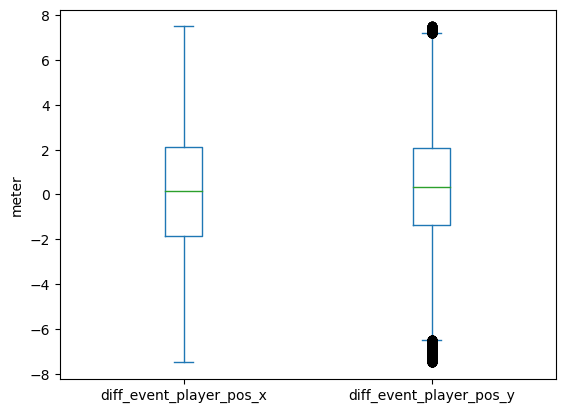

In [243]:
diff_x = combined['x'] - combined['carrier_x']
diff_y = combined['y'] - combined['carrier_y']
pbdf = pd.concat([diff_x, diff_y], axis=1)
pbdf.columns = ['diff_event_player_pos_x', 'diff_event_player_pos_y']
ax = pbdf.plot.box()
ax.set_ylabel('meter')

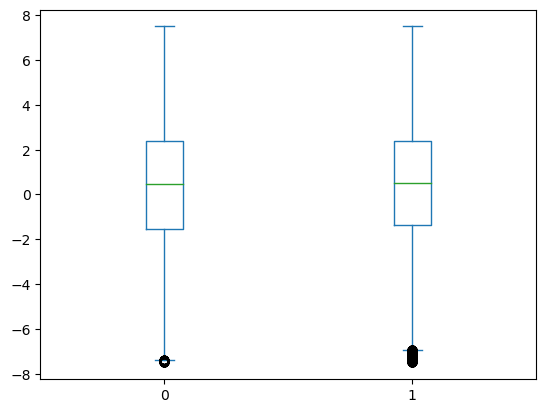

In [242]:
rec_x = combined['Pass_end_x'] - combined['recipient_x']
rec_y = combined['Pass_end_y'] - combined['recipient_y']
pbdf = pd.concat([rec_x, rec_y], axis=1)
ax = pbdf.plot.box()

In [240]:
combined = combined.drop(combined[(abs(combined['x'] - combined['carrier_x']) > 7.5) | (abs(combined['y'] - combined['carrier_y']) > 7.5)].index)

In [241]:
combined = combined.drop(combined[(abs(combined['Pass_end_x'] - combined['recipient_x']) > 7.5) | (abs(combined['Pass_end_y'] - combined['recipient_y']) > 7.5)].index)

In [244]:
import math
import sklearn.metrics
def identify_through_pass_2(recipient_location, forward_pass, def1, def2, def3, y_dist, number=0):
    # for offsides, maybe check if the first attacking is behind the last def - but the first attacker is not guaranteed to be the recipient in the next frame
    if forward_pass:
        # nothing to compare with
        if type(def1) is not list:
            return False
        # if the recipient has 0 defenders ahead -> he is behind every defender
        if def1[0] < recipient_location[0]:
            return True
        # We let 1 defender to be ahead, but with at least x metres difference in y axis
        elif number == 1:
            if type(def2) is not list:
                return True # not sure
            if abs(def1[1] - recipient_location[1]) > y_dist and def2[0] < recipient_location[0]:
                return True
            else:
                return False
        # We let 2 defenders to be ahead, but with at least 10 metres difference in y axis
        elif number == 2:
            if type(def2) is not list or type(def3) is not list:
                return True # not sure
            if abs(def1[1] - recipient_location[1]) > y_dist and abs(def2[1] - recipient_location[1]) > y_dist and def3[0] < recipient_location[0]:
                return True
            else:
                return False
        else:
            return False
    else:
        return False
def identify_forward_pass(team_id, next_team_id, carrier_loc, recipient_loc, progress):
    # progress is at least 2-3 in direction x (excluding crosses or trying to)
    if type(carrier_loc) is not list or type(recipient_loc) is not list:
        return False
    else:
        return (recipient_loc[0]>carrier_loc[0]) and (team_id == next_team_id) and (recipient_loc[0] < 120) and math.sqrt(np.square(recipient_loc[0] - (carrier_loc[0]) + np.square(recipient_loc[1] - carrier_loc[1])) > progress)    
# try to exclude crosses a different way
def identify_forward_pass_without_cross(team_id, next_team_id, carrier_loc, recipient_loc, carrier_tr, rec_tr):
    # progress is at least 2-3 in direction x (excluding crosses or trying to)
    if type(carrier_loc) is not list or type(recipient_loc) is not list:
        return False
    if carrier_tr == rec_tr: #avoid carries
        return False
    else:
        if (recipient_loc[0]>carrier_loc[0]) and (team_id == next_team_id) and (recipient_loc[0] < 120):
            if np.arctan(abs(recipient_loc[1]-carrier_loc[1])/abs(recipient_loc[0]-carrier_loc[0])) / np.pi * 180 < 45:
                return True
            else:
                return False                
        else:
            return False
def identify_offside_pass(team_id, next_team_id, last_def, rec):
    if team_id == next_team_id and rec[0] > last_def[0] and last_def != rec:
        return True
    else:
        return False
def calc_dist_to_goal(location):
    if type(location) is not list:
        return np.nan
    else:
        return math.sqrt(np.square(105 - location[0]) + np.square(34 - location[1]))
def identify_through_pass_by_event(team, next_team, pos, next_pos, progress, front):
    if type(pos) is not list or type(next_pos) is not list:
        return False
    dist = calc_dist_to_goal(pos)
    next_dist = calc_dist_to_goal(next_pos)
    if team == next_team:
        return ((next_dist / dist < progress) & (pos[0] > front))
    return False
def goal_in_next_evs(row):
    return any(row['through_pass':'through_pass'+3] == True)
def sum_up_evals_tracking(test_case, filter_case, test_series, pred, offside_ratio, min_y):
    acc = sklearn.metrics.accuracy_score(test_series, pred)
    roc_auc = sklearn.metrics.roc_auc_score(test_series, pred)
    recall = sklearn.metrics.recall_score(test_series, pred)
    prec = sklearn.metrics.precision_score(test_series, pred)
    f1_sc = sklearn.metrics.f1_score(test_series, pred)
    found_through_passes = pred.sum()
    confusion_mx = sklearn.metrics.confusion_matrix(test_series, pred)
    res = {'tested_by': test_case, 'defenders_ahead': filter_case, 'min_y_dist_to_defenders': min_y, 'accuracy': acc, 'roc_auc': roc_auc, 'recall': recall, 'precision': prec, 'f1-score': f1_sc, 'number_of_identified_through_passes': found_through_passes, 'found_t_p_s': confusion_mx[1][1], 'through_pass_after_offside_ratio': offside_ratio}
    print(res)
    res['results'] = pred
    return res
def sum_up_evals_event(higher, progress, test_case, test_series, pred):
    acc = sklearn.metrics.accuracy_score(test_series, pred)
    roc_auc = sklearn.metrics.roc_auc_score(test_series, pred)
    recall = sklearn.metrics.recall_score(test_series, pred)
    prec = sklearn.metrics.precision_score(test_series, pred)
    f1_sc = sklearn.metrics.f1_score(test_series, pred)
    found_through_passes = pred.sum()
    confusion_mx = sklearn.metrics.confusion_matrix(test_series, pred)
    return {'pass_progress(%)': 100-(progress*100), 'recipient_x_pos_greater_than': higher, 'tested_by': test_case, 'accuracy': acc, 'roc_auc': roc_auc, 'recall': recall, 'precision': prec, 'f1-score': f1_sc, 'number_of_identified_through_passes': found_through_passes, 'found_t_p_s': confusion_mx[1][1]}


In [245]:
combined['forward_pass'] = combined.apply(lambda x: identify_forward_pass_without_cross(x['event_team'], x['event_team_next'], [x['x'], x['y']], [x['Pass_end_x'], x['Pass_end_y']], [x['x'], x['y']], [x['Pass_end_x'], x['Pass_end_y']]), axis=1)
combined['offside_pass'] = combined.apply(lambda x: identify_offside_pass(x['event_team'], x['event_team_next'], [x['defender_1_x'], x['defender_1_y']], [x['recipient_x_before'], x['recipient_y_before']]), axis=1)
successful_through_pass_by_label = (combined['through_pass_by_label']) & (combined['outcome'])
tracking_test_cases = []
pred_through_pass_by_tracking_without_offs_0 = combined.apply(lambda x: identify_through_pass_2([x['Pass_end_x'], x['Pass_end_y']], x['forward_pass'], [x['defender_1_x_end'], x['defender_1_y_end']], [x['defender_2_x_end'], x['defender_2_y_end']], [x['defender_3_x_end'], x['defender_3_y_end']], 5, number=0), axis=1)
pred_through_pass_by_tracking_0 = ~combined['offside_pass'] & pred_through_pass_by_tracking_without_offs_0
pred_through_pass_by_tracking_offside_ratio_0 = (1 - (pred_through_pass_by_tracking_0.sum() / pred_through_pass_by_tracking_without_offs_0.sum()))
tracking_test_cases.append(sum_up_evals_tracking('through_pass_by_label', 0, combined['through_pass_by_label'], pred_through_pass_by_tracking_0, pred_through_pass_by_tracking_offside_ratio_0, 5))
tracking_test_cases.append(sum_up_evals_tracking('successful_through_pass_by_label', 0, successful_through_pass_by_label, pred_through_pass_by_tracking_0, pred_through_pass_by_tracking_offside_ratio_0, 5))
for i in range(1, 5):    
    pred_through_pass_by_tracking_without_offs_1 = combined.apply(lambda x: identify_through_pass_2([x['Pass_end_x'], x['Pass_end_y']], x['forward_pass'], [x['defender_1_x_end'], x['defender_1_y_end']], [x['defender_2_x_end'], x['defender_2_y_end']], [x['defender_3_x_end'], x['defender_3_y_end']], i*5, number=1), axis=1)
    pred_through_pass_by_tracking_without_offs_2 = combined.apply(lambda x: identify_through_pass_2([x['Pass_end_x'], x['Pass_end_y']], x['forward_pass'], [x['defender_1_x_end'], x['defender_1_y_end']], [x['defender_2_x_end'], x['defender_2_y_end']], [x['defender_3_x_end'], x['defender_3_y_end']], i*5, number=2), axis=1)
    pred_through_pass_by_tracking_1 = ~combined['offside_pass'] & pred_through_pass_by_tracking_without_offs_1
    pred_through_pass_by_tracking_offside_ratio_1 = (1 - (pred_through_pass_by_tracking_1.sum() / pred_through_pass_by_tracking_without_offs_1.sum()))
    pred_through_pass_by_tracking_2 = ~combined['offside_pass'] & pred_through_pass_by_tracking_without_offs_2
    pred_through_pass_by_tracking_offside_ratio_2 = (1 - (pred_through_pass_by_tracking_2.sum() / pred_through_pass_by_tracking_without_offs_2.sum()))
    tracking_test_cases.append(sum_up_evals_tracking('through_pass_by_label', 1, combined['through_pass_by_label'], pred_through_pass_by_tracking_1, pred_through_pass_by_tracking_offside_ratio_1, i*5))
    tracking_test_cases.append(sum_up_evals_tracking('successful_through_pass_by_label', 1, successful_through_pass_by_label, pred_through_pass_by_tracking_1, pred_through_pass_by_tracking_offside_ratio_1, i*5))
    tracking_test_cases.append(sum_up_evals_tracking('through_pass_by_label', 2, combined['through_pass_by_label'], pred_through_pass_by_tracking_2, pred_through_pass_by_tracking_offside_ratio_2, i*5))
    tracking_test_cases.append(sum_up_evals_tracking('successful_through_pass_by_label', 2, successful_through_pass_by_label, pred_through_pass_by_tracking_2, pred_through_pass_by_tracking_offside_ratio_2, i*5))
tracking_test_cases_df = pd.DataFrame(tracking_test_cases)

{'tested_by': 'through_pass_by_label', 'defenders_ahead': 0, 'min_y_dist_to_defenders': 5, 'accuracy': 0.9824302377085486, 'roc_auc': 0.6376375159187428, 'recall': 0.291970802919708, 'precision': 0.02165674066053059, 'f1-score': 0.04032258064516129, 'number_of_identified_through_passes': 1847, 'found_t_p_s': 40, 'through_pass_after_offside_ratio': 0.061006609049313654}
{'tested_by': 'successful_through_pass_by_label', 'defenders_ahead': 0, 'min_y_dist_to_defenders': 5, 'accuracy': 0.9831038683006054, 'roc_auc': 0.8061694077056464, 'recall': 0.6290322580645161, 'precision': 0.021115322144017325, 'f1-score': 0.04085908852802514, 'number_of_identified_through_passes': 1847, 'found_t_p_s': 39, 'through_pass_after_offside_ratio': 0.061006609049313654}
{'tested_by': 'through_pass_by_label', 'defenders_ahead': 1, 'min_y_dist_to_defenders': 5, 'accuracy': 0.9772811161966632, 'roc_auc': 0.6423497268312364, 'recall': 0.30656934306569344, 'precision': 0.017434620174346202, 'f1-score': 0.032992930

In [246]:
max_id = tracking_test_cases_df['roc_auc'].idxmax()
best_res = tracking_test_cases_df.iloc[max_id]['results']

In [247]:
event_test_cases = []
for j in range(0,6):
    progress = 0.40 + 0.10 * j #(0.1.2.3.4.5.6.7, currently 1)
    for k in range(0,5):
        front = 15 * (k + 1) #(1.2.3.4.5.6.7.8, currently 1)
        pred_through_pass_by_ev = combined.apply(lambda x: identify_through_pass_by_event(x['event_team'], x['event_team_next'], [x['x'], x['y']], [x['Pass_end_x'], x['Pass_end_y']], progress, front), axis=1)
        res1 = sum_up_evals_event(front, progress, 'through_pass_by_label', combined['through_pass_by_label'], pred_through_pass_by_ev)
        print(res1)
        event_test_cases.append(res1)
        res2 = sum_up_evals_event(front, progress, 'successful_through_pass_by_label', successful_through_pass_by_label, pred_through_pass_by_ev) 
        print(res2)
        event_test_cases.append(res2)
event_test_cases_df = pd.DataFrame(event_test_cases)

{'pass_progress(%)': 60.0, 'recipient_x_pos_greater_than': 15, 'tested_by': 'through_pass_by_label', 'accuracy': 0.9908829174664108, 'roc_auc': 0.5434537927696822, 'recall': 0.0948905109489051, 'precision': 0.014823261117445839, 'f1-score': 0.02564102564102564, 'number_of_identified_through_passes': 877, 'found_t_p_s': 13}
{'pass_progress(%)': 60.0, 'recipient_x_pos_greater_than': 15, 'tested_by': 'successful_through_pass_by_label', 'accuracy': 0.9915750036911265, 'roc_auc': 0.6008500109903661, 'recall': 0.20967741935483872, 'precision': 0.014823261117445839, 'f1-score': 0.027689030883919063, 'number_of_identified_through_passes': 877, 'found_t_p_s': 13}
{'pass_progress(%)': 60.0, 'recipient_x_pos_greater_than': 30, 'tested_by': 'through_pass_by_label', 'accuracy': 0.9911689797726266, 'roc_auc': 0.5399519896852143, 'recall': 0.08759124087591241, 'precision': 0.014218009478672985, 'f1-score': 0.024464831804281346, 'number_of_identified_through_passes': 844, 'found_t_p_s': 12}
{'pass_pro

In [115]:
test_series = pred_through_pass_by_tracking_1.copy().reset_index(drop=True)
found_passes = test_series[test_series].index.values
combined = combined.reset_index(drop=True)
identified_passes = combined.iloc[found_passes]
identified_passes = identified_passes[['x', 'y', 'Pass_end_x', 'Pass_end_y', 'defender_1_x_end', 'defender_1_y_end', 'defender_2_x_end', 'defender_2_y_end', 'defender_3_x_end', 'defender_3_y_end', 'through_pass_by_label', 'outcome', 'offside_by_label', 'free_kick_by_label', 'head_pass_by_label', 'cross_by_label', 'ball_z']]
identified_passes['diff'] = identified_passes['Pass_end_x'] - identified_passes['x']
real_t_p = calc_combined[calc_combined['through_pass_by_label']]
real_t_p = real_t_p[['x', 'y', 'Pass_end_x', 'Pass_end_y', 'defender_1_x_end', 'defender_1_y_end', 'defender_2_x_end', 'defender_2_y_end', 'defender_3_x_end', 'defender_3_y_end', 'through_pass_by_label', 'pass_by_label', 'offside_by_label', 'forward_pass', 'event_team', 'event_team_next', 'outcome']]

In [248]:
combined['through_pass'] = best_res
goal_analysis = combined.groupby(['matchId', 'sequenceId']).agg({'through_pass': 'sum', 'goal_by_label': 'sum'})

In [249]:
tp_goal_seq = goal_analysis['goal_by_label'] & goal_analysis['through_pass']
print(tp_goal_seq.sum() / goal_analysis['goal_by_label'].sum())
print(tp_goal_seq.sum() / goal_analysis['through_pass'].sum())

0.11176470588235295
0.017124831004957188


In [250]:
combined.dropna(subset=['event_team_next', 'Pass_end_x', 'Pass_end_y', 'ball_x', 'ball_y', 'ball_z', 'ball_x_n_sec_before', 'ball_y_n_sec_before', 'ball_z_n_sec_before', 'ball_x_end', 'ball_y_end', 'ball_z_end', 'recipient_x'], axis=0, inplace=True)

In [251]:
combined['pass_length'] = combined.apply(calc_pass_length, axis=1)

1
2
3
4
5
1
2
3
26


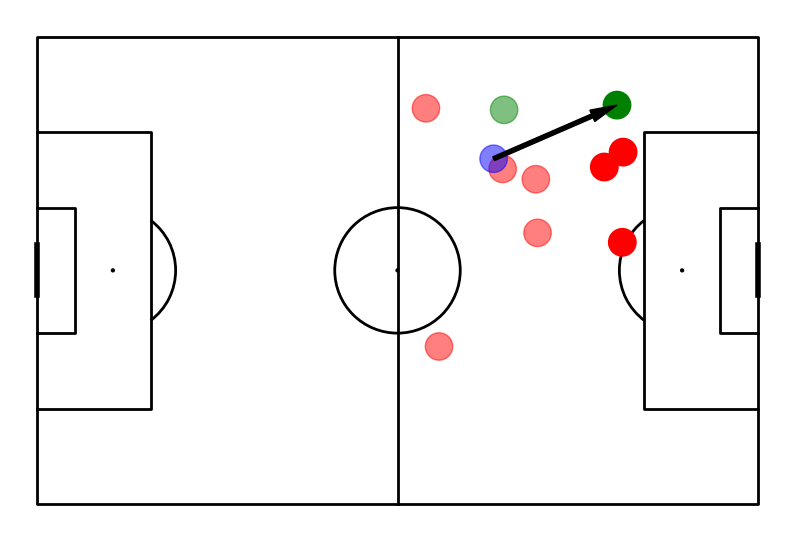

In [272]:
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch

# Create a Pitch object
mypitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68, line_color = "black")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the pitch
mypitch.draw(ax=ax)
number = 0

# Customize other plot elements (e.g., players, ball, etc.) as needed
for i,thepass in combined.iterrows():
    if number > 0:
        break
    if thepass['through_pass'] == 1:
        #plot circle
        for num in range(1,6):
            print(num)
            passCircle=plt.Circle((thepass[f'defender_{num}_x'],thepass[f'defender_{num}_y']),2,color='red')
            passCircle.set_alpha(.5)
            ax.add_patch(passCircle)
            # passCircle2=plt.Circle((thepass[f'attacker_{num}_x'],thepass[f'attacker_{num}_y']),2,color='blue')
            # passCircle2.set_alpha(.5)
            # ax.add_patch(passCircle2)
        for num in range(1,4):
            print(num)
            passCircle=plt.Circle((thepass[f'defender_{num}_x_end'],thepass[f'defender_{num}_y_end']),2,color='red')
            #passCircle.set_alpha(.5)
            ax.add_patch(passCircle)
            #passCircle2=plt.Circle((thepass[f'attacker_{num}_x_end'],thepass[f'attacker_{num}_y_end']),2,color='blue')
            #passCircle2.set_alpha(.5)
            #ax.add_patch(passCircle2)                    
        rPassCircle=plt.Circle((thepass[f'recipient_x_before'],thepass[f'recipient_y_before']),2,color='green')
        rPassCircle.set_alpha(.5)
        ax.add_patch(rPassCircle)                            
        rPassCircle=plt.Circle((thepass[f'recipient_x'],thepass[f'recipient_y']),2,color='green')
        #rPassCircle.set_alpha(.5)
        ax.add_patch(rPassCircle)
        rPassCircle=plt.Circle((thepass[f'carrier_x'],thepass[f'carrier_y']),2,color='blue')
        rPassCircle.set_alpha(.5)
        ax.add_patch(rPassCircle)
        px=thepass['recipient_x'] - thepass['carrier_x']
        py=thepass['recipient_y'] - thepass['carrier_y']
        print(i)
        #plot arrow
        passArrow=plt.Arrow(thepass['carrier_x'],thepass['carrier_y'],px,py,width=3,color='black')
        ax.add_patch(passArrow)
        number = number + 1

# Show the plot
plt.show()        

In [252]:
#combined['through_pass'] = pred_through_pass_by_tracking_1
combined['through_pass'] = combined['through_pass'].astype(int)

In [253]:
combined.drop(['forward_pass'], axis=1, inplace=True)
combined.drop(['pass_by_label', 'offside_by_label', 'free_kick_by_label', 'cross_by_label', 'head_pass_by_label'], axis=1, inplace=True)
combined.drop(['offside_pass', 'goal_by_label'], axis=1, inplace=True)
combined.drop(['through_pass_by_label'], axis=1, inplace=True)
combined.drop(['sequenceId', 'matchId'], axis=1, inplace=True)

In [255]:
combined.dropna(inplace=True)

In [254]:
len(combined[combined.isna().any(axis=1)])

2003

In [257]:
combined.reset_index(drop=True, inplace=True)

In [258]:
#predict pre-event
combined_ml = combined.copy()
to_drop = [i for i in combined_ml.columns if i == 'pass_length' or i == 'outcome' or i == 'event_team_next' or 'recipient' in i or '_end' in i or i == 'event_team']
combined_ml.drop(to_drop, axis=1, inplace=True)

In [259]:
#predict from every feature possible
combined_ml2 = combined.copy()

In [260]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def preproc(comb_dataset):
    Y = comb_dataset['through_pass'].reset_index(drop=True)
    x = comb_dataset.drop('through_pass', axis=1).values #numpy 2d array
    x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.2, random_state=42)
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(x_train)
    x_train_scaled = min_max_scaler.transform(x_train)
    x_test_scaled = min_max_scaler.transform(x_test)
    x_train_scaled = pd.DataFrame(x_train_scaled)
    x_test_scaled = pd.DataFrame(x_test_scaled)
    columns = comb_dataset.columns.tolist()
    columns.remove('through_pass')
    x_train_scaled = x_train_scaled.set_axis(columns, axis='columns', copy=False)
    x_test_scaled = x_test_scaled.set_axis(columns, axis='columns', copy=False)
    X_train = x_train_scaled.reset_index(drop=True)
    X_test = x_test_scaled.reset_index(drop=True)
    return X_train, X_test, y_train, y_test

In [221]:
def feature_elimination(x_train, x_test, y_train):
    vars = x_train.agg("var", numeric_only=True)
    x_train = x_train.drop(columns=vars[vars.between(0, 0.001)].index)
    x_test = x_test.drop(columns=vars[vars.between(0, 0.001)].index)
    # norm_comb = pd.concat([x_train, y_train], axis=1)
    # corr_matrix = norm_comb.corr()
    # iters = range(len(corr_matrix.columns) - 1)
    # drop_cols = []
    # for i in iters:
    #     for j in range(i+1):
    #             item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
    #             col = item.columns
    #             row = item.index
    #             val = abs(item.values)
    #             # If correlation exceeds the threshold
    #             if val >= 0.5:
    #                 # Print the correlated features and the correlation value
    #                 # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
    #                 drop_cols.append(col.values[0])
    # drops = set(drop_cols)
    # x_train.drop(drops, axis=1, inplace=True)
    # x_test.drop(drops, axis=1, inplace=True)
    norm_comb = pd.concat([x_train, y_train], axis=1)
    cor = norm_comb.corr()
    cor_target = abs(cor['through_pass'])
    irelevant_features = cor_target[cor_target<0.001]
    cols = list([i for i in irelevant_features.index])
    x_train = x_train.drop(cols, axis=1)
    x_test = x_test.drop(cols, axis=1)
    return x_train, x_test, y_train

In [261]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def rfes(x_train, y_train):
    features = []
    estimators = [SGDClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
    for est in estimators:
        for i in range(0,2):
            nf = random.randint(7,30)
            s = random.randint(2,8)
            selector = RFE(est, n_features_to_select=nf, step=s)
            selector = selector.fit(x_train, y_train)
            features.append(selector)
    return features

In [267]:
def train_and_test_model(model_and_params, method, X_train, X_test, Y_train, Y_test):
    #x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
    oversample = SMOTE(sampling_strategy=0.15)
    x_train, y_train = oversample.fit_resample(X_train, Y_train)
    h_param_tuning = RandomizedSearchCV(estimator=model_and_params[0], param_distributions=model_and_params[1], cv=4, n_jobs=-1, scoring = "f1")
    h_param_tuning.fit(x_train, y_train)
    m_i = model_and_params[0].set_params(**h_param_tuning.best_params_)
    m_i = m_i.fit(x_train, y_train)
    pred = m_i.predict(X_test)
    acc = sklearn.metrics.accuracy_score(Y_test, pred)
    prec = sklearn.metrics.precision_score(Y_test, pred)
    f1s = sklearn.metrics.f1_score(Y_test, pred)
    rec = sklearn.metrics.recall_score(Y_test, pred)
    roc = sklearn.metrics.roc_auc_score(Y_test, pred)
    # res = {'model': m_i.__str__().split('(')[1], 'method': method, 'accuracy': acc, 'roc_auc': roc, 'precision': prec, 'recall': rec, 'f1-score': f1s}
    res = {'model': m_i.__str__().split('(')[0], 'method': method, 'accuracy': acc, 'roc_auc': roc, 'precision': prec, 'recall': rec, 'f1-score': f1s, 'model_params': h_param_tuning.best_params_, 'model_inst': m_i}
    print(res)
    return res, h_param_tuning

In [266]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

def train_and_test_stacked_model(models, method, X_train, X_test, Y_train, Y_test):
    oversample = SMOTE(sampling_strategy=0.15)
    x_train, y_train = oversample.fit_resample(X_train, Y_train)
    estimators = [(m.__str__()[0:3], m) for m in models]
    print(estimators)
    #estimators = [('df', DecisionTreeClassifier()), ('kn', KNeighborsClassifier()), ('rf', RandomForestClassifier()),('gb', GradientBoostingClassifier())]
    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    clf = clf.fit(x_train, y_train)
    pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(Y_test, pred)
    prec = sklearn.metrics.precision_score(Y_test, pred)
    f1s = sklearn.metrics.f1_score(Y_test, pred)
    rec = sklearn.metrics.recall_score(Y_test, pred)
    roc = sklearn.metrics.roc_auc_score(Y_test, pred)
    res = {'model': clf.__str__().split('(')[0], 'method': method, 'accuracy': acc, 'roc_auc': roc, 'precision': prec, 'recall': rec, 'f1-score': f1s, 'model_inst': clf}
    print(res)
    return res

In [268]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from imblearn.over_sampling import SMOTE

def compute_results(og_combined):
    x_train, x_test, y_train, y_test = preproc(og_combined)
    res_list = []
    models = [(DecisionTreeClassifier(), {
        'max_depth': [3, None],
        'min_samples_split': randint(2,12),
        'min_samples_leaf': randint(1,12),
        'criterion': ['gini', 'entropy', 'log_loss']
        }), 
        (KNeighborsClassifier(), {
        'n_neighbors': randint(1,20), 
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'weights': ['uniform', 'distance']
        }), 
        (RandomForestClassifier(), {
        'n_estimators': np.arange(30, 300, step=10),
        'max_depth': [3, None],
        'min_samples_split': randint(2,12),
        'min_samples_leaf': randint(1,12),
        'criterion': ['gini', 'entropy', 'log_loss'],
        'bootstrap': [True, False]
        }), 
        (HistGradientBoostingClassifier(), {
        'max_depth': [3, None],
        'min_samples_leaf': randint(1,12),
        'max_iter': np.arange(30, 300, step=10),
        'learning_rate': [i * 0.1 for i in range(1,11)],
        }), 
        (LinearSVC(), {
        'C':0.1 * np.arange(1, 101, step=10), 
        'max_iter': np.arange(200, 2000, step=100),
        'loss': ['hinge', 'squared_hinge']
    })]
    x1_train, x1_test, y1_train = feature_elimination(x_train, x_test, y_train)
    features = rfes(x1_train, y1_train)
    for feature in features:
        x2_train = x1_train.loc[:, feature.get_support()]
        x2_test = x1_test.loc[:, feature.get_support()]
        models_for_stacking = []
        for m in models:
            model_for_stacking = m[0]
            res, hyperparams = train_and_test_model(m, 'RFE: '+feature.__str__(), x2_train, x2_test, y_train, y_test)
            res_list.append(res)
            model_for_stacking.set_params(**hyperparams.best_params_)
            models_for_stacking.append(model_for_stacking)
        res = train_and_test_stacked_model(models_for_stacking, 'RFE: '+feature.__str__(), x2_train, x2_test, y_train, y_test)
        res_list.append(res)
    return pd.DataFrame(res_list), features

In [269]:
res1, features1c = compute_results(combined_ml)
res2, features2c = compute_results(combined_ml2)

{'model': 'DecisionTreeClassifier', 'method': 'RFE: RFE(estimator=SGDClassifier(), n_features_to_select=26, step=6)', 'accuracy': 0.9282327841649876, 'roc_auc': 0.5451107460143604, 'precision': 0.06927374301675977, 'recall': 0.1409090909090909, 'f1-score': 0.09288389513108612, 'model_params': {'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 2}, 'model_inst': DecisionTreeClassifier(criterion='log_loss', min_samples_leaf=6)}
{'model': 'KNeighborsClassifier', 'method': 'RFE: RFE(estimator=SGDClassifier(), n_features_to_select=26, step=6)', 'accuracy': 0.917387697048714, 'roc_auc': 0.5660855543385664, 'precision': 0.0763765541740675, 'recall': 0.19545454545454546, 'f1-score': 0.10983397190293742, 'model_params': {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}, 'model_inst': KNeighborsClassifier(n_neighbors=1)}
{'model': 'RandomForestClassifier', 'method': 'RFE: RFE(estimator=SGDClassifier(), n_features_to_select=26, step=6)', 'accuracy'

In [278]:
features_imp = None
res2_sorted = res2.sort_values(['f1-score'], ascending=False)
for r_i,res in res2_sorted.iterrows():
    try:
        features_imp = pd.Series(res['model_inst'].feature_importances_, index=res['model_inst'].feature_names_in_.tolist())
    except:
        continue
    else:
        print(res)
        break
features_imp.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\features_importance_v2.csv", index=True)
features_imp

model                                      RandomForestClassifier
method          RFE: RFE(estimator=SGDClassifier(), n_features...
accuracy                                                 0.987199
roc_auc                                                  0.893894
precision                                                0.735294
recall                                                   0.795455
f1-score                                                 0.764192
model_params    {'bootstrap': False, 'criterion': 'log_loss', ...
model_inst      (DecisionTreeClassifier(criterion='entropy', m...
Name: 8, dtype: object


Pass_end_x                   0.227367
attacker_1_x                 0.024396
ball_y                       0.012276
carrier_x                    0.021730
defender_1_x                 0.021635
defender_1_x_n_sec_before    0.017702
defender_2_x                 0.027627
defender_2_x_n_sec_before    0.022292
defender_3_x                 0.018843
defender_4_x                 0.017098
defender_4_x_n_sec_before    0.019667
recipient_dist_to_def        0.101842
recipient_dist_to_def_x      0.080873
recipient_x_before           0.061642
recipient_y_before           0.014775
x                            0.024724
defender_1_x_end             0.041754
defender_2_x_end             0.047675
recipient_x                  0.114920
recipient_y                  0.014527
outcome                      0.034208
pass_length                  0.032426
dtype: float64

In [271]:
res1.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\pre_event_prediction_v6.csv", index=False)
res2.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\post_event_prediction_v6.csv", index=False)

In [270]:
tracking_test_cases_df.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\tracking_w_labels_v2.csv", index=False)
event_test_cases_df.to_csv("E:\EGYETEM\\7_felev\\szakdoga_statsperform\\data\\event_w_labels_v2.csv", index=False)